# Config file of an example using LSTM-KF-RL on a synthetic time series
This file include 
1. import data
2. training BDLM-LSTM model with hyper-parameters-free AR
3. check if the BDLM-LSTM model is correct (LSTM, AR, AA)
4. generate time series for RL agent training
5. train RL agents
6. evaluate the performance of RL agents

In [1]:
import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI-LSTM')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import csv
import pandas as pd
import copy
import scipy.io as sio

from tqdm import tqdm
from datetime import datetime, timedelta
from src.RL_functions.generate_synthetic_time_series import *
from examples.data_loader import TimeSeriesDataloader
from pytagi import Normalizer as normalizer
from pytagi.nn import LSTM, Linear, OutputUpdater, Sequential
from pytagi.hybrid import LSTM_SSM
from pytagi.hybrid import process_input_ssm
import pytagi.metric as metric
from pytagi import Normalizer

from src.RL_functions.generate_one_synthetic_time_series import generate_one_synthetic_time_series
from src.RL_functions.BDLM_trainer import BDLM_trainer
from src.RL_functions.regime_change_detection_RLKF import regime_change_detection_RLKF

## 1. Import data

In [2]:
# Import data HQ TS2
time_series_path = './data/HQ/CASC_LGA007PIAP_E010_2024_07.mat'
data = sio.loadmat(time_series_path)
timestamps = data['values'][:, 1][0].T[0][368:]
y_disp = data['values'][:, 3][0].T[0][368:].tolist()
time_covariates = ['week_of_year']
obs_file_paths = ['data/CASC_LGA007PIAP_E010_2024_07/ytrain_obs.csv', 'data/CASC_LGA007PIAP_E010_2024_07/yval_obs.csv', 'data/CASC_LGA007PIAP_E010_2024_07/ytest_obs.csv']
date_file_paths=['data/CASC_LGA007PIAP_E010_2024_07/ytrain_datetime.csv', 'data/CASC_LGA007PIAP_E010_2024_07/yval_datetime.csv', 'data/CASC_LGA007PIAP_E010_2024_07/ytest_datetime.csv']

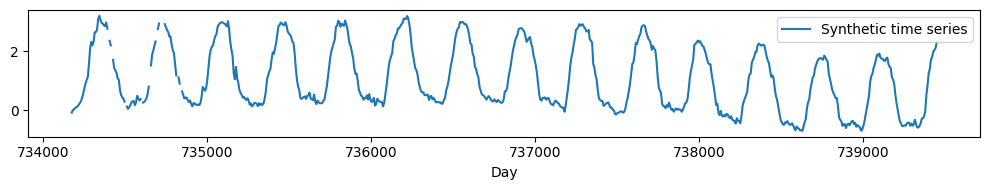

In [3]:
data_preprocessor = generate_one_synthetic_time_series(used_for_generation=False)
data_preprocessor.time_series['y'] = y_disp
data_preprocessor.time_series['timesteps'] = timestamps
data_preprocessor.time_step_interval = 7
data_preprocessor.export_to_csv(indices_train_val_test=[216, 268, -1],
                     observation_file_paths = obs_file_paths,
                     datetime_file_paths=date_file_paths,
                     start_datetime=datetime(2010, 2, 7, 12, 0, 0))
val_datetime_values = data_preprocessor.get_validation_datetime_values()
data_preprocessor.plot()

## 2. Train BDLM
The components are AA + AR + LSTM. The AR component here learns automatically the phi_AR and sigma_AR

### BDLM training configuration

In [4]:
num_epochs: int = 30
batch_size: int = 1
sigma_v: float = 1E-12

"""Run training for time-series forecasting model"""
# Dataset
output_col = [0]
num_features = 2
input_seq_len = 26
output_seq_len = 1
seq_stride = 1

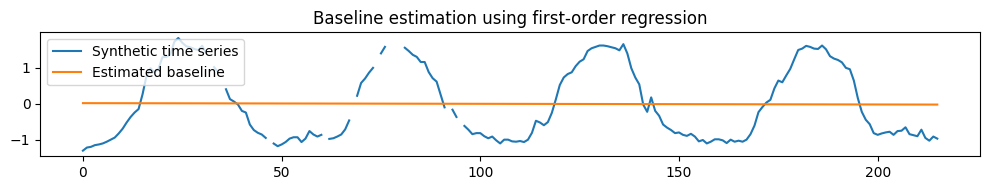

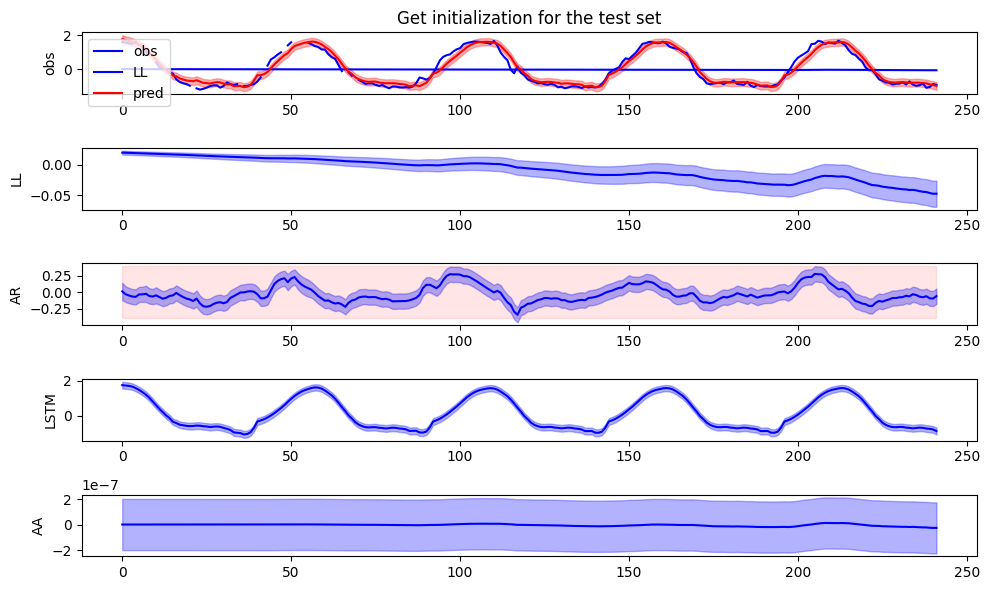

In [5]:
BDLM = BDLM_trainer(num_epochs=num_epochs,
                    batch_size=batch_size,
                    sigma_v=sigma_v,
                    output_col=output_col,
                    num_features=num_features,
                    input_seq_len=input_seq_len,
                    output_seq_len=output_seq_len,
                    seq_stride=seq_stride)
BDLM.load_datasets(obs_file_paths, date_file_paths, time_covariates)
BDLM.estimate_initial_baseline(plot=True)

# BDLM.train(plot=True, early_stopping=True, patience=10)
# BDLM.save_LSTM_model(path = './saved_param/CASC_LGA007PIAP_E010_2024_07/lstm_y_V2.pth')
# # Store the smoothed initial value from training + validation sets, and remove the phi_AR hidden state
# print(BDLM.phi_AR)
# print(BDLM.Sigma_AR)
# print(BDLM.var_phi_AR)
# print(BDLM.var_Sigma_AR)

BDLM.phi_AR = 0.7222478052030589
BDLM.Sigma_AR = 0.0080873570245455
BDLM.var_phi_AR = 0.006625828644560832
BDLM.var_Sigma_AR = 6.923906665191422e-06

BDLM.load_LSTM_model(path = './saved_param/CASC_LGA007PIAP_E010_2024_07/lstm_y_V2.pth')

LSTM_net, init_mu_lstm, init_var_lstm, init_z, init_Sz, init_mu_W2b, init_var_W2b,\
last_seq_obs, last_seq_datetime, last_lstm_x = BDLM.get_testing_model_initials(val_datetime_values=val_datetime_values, plot=True)
init_z[2]=0

## 3. Check if AA is correct

In [6]:
# BDLM.check_AA(plot = True)

## 4. RL agent

In [7]:
# Training RL
# Initialize environment
from pytagi.LSTM_KF_RL_Env import LSTM_KF_Env
train_dtl = BDLM.train_dtl
env = LSTM_KF_Env(render_mode=None, data_loader=train_dtl, \
                    ts_model=BDLM.model, step_look_back=64)
state, _ = env.reset(z=init_z, Sz=init_Sz, mu_preds_lstm = copy.deepcopy(init_mu_lstm), var_preds_lstm = copy.deepcopy(init_var_lstm),\
                    net_test=LSTM_net, init_mu_W2b=init_mu_W2b, init_var_W2b=init_var_W2b, phi_AR=BDLM.phi_AR, Sigma_AR=BDLM.Sigma_AR,
                    phi_AA = BDLM.phi_AA, Sigma_AA_ratio = BDLM.Sigma_AA_ratio)
n_actions = env.action_space.n
n_observations = len(state['hidden_states'])

agents_RL = regime_change_detection_RLKF(trained_BDLM = BDLM, val_datetime_values = val_datetime_values,
                                         n_observations = n_observations, n_actions = n_actions)
agent_model_path = './saved_param/CASC_LGA007PIAP_E010_2024_07/DQN_agent_net7.pth'
# # # Generate synthetic time series
# agents_RL.generate_synthetic_ts(num_syn_ts = 200, syn_ts_len = 52 * 6)
# agents_RL.save_synthetic_ts(datetime_save_path='data/CASC_LGA007PIAP_E010_2024_07/RLDS_y_datetime_200episodes_V2.csv',
#                             observation_save_path='data/CASC_LGA007PIAP_E010_2024_07/RLDS_y_observation_200episodes_V2.csv')

[19.  1.  0.  0.  1.  0.  0. 11.  2.  6.  5.  4.  1. 30.  1.  2.  2.  0.
  3.  2. 11.  1.  5.  3.  6.  4.  4.  3.  2.  4.  3.  3.  4.  5.  3.  4.
  6.  5.  3.  4.  1.  4.  3.  4.  2.  5.  5.  8.  7.  2.  2.  2.  2.  7.
  5.  2.  1.  2.  2.  3.  1.  1.  3.  3.  2.  4.  1.  2.  1.  3.  4. 12.
  3.  1.  2.  4.  3.  2.  4.  3. 10.  4.  1.  6.  2.  4.  3.  2.  3.  4.
  3.  4.  4.  5.  2.  2.  4.  1.  2.  4.  6.  2.  1.  1. 11.  0.  1.  1.
  2.  3.  1.  2.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[0.43115053642944656, 0.5557874973551025, 0.27686475480067235, 0.2930387769172745, 0.2623699265859429, 0.2533007840755031, 0.2245206756478683, 0.3886762980988442, 0.4873191454955539, 0.2559863309512678, 0.503469574395156, 0.4919643353961889]


<Figure size 640x480 with 0 Axes>

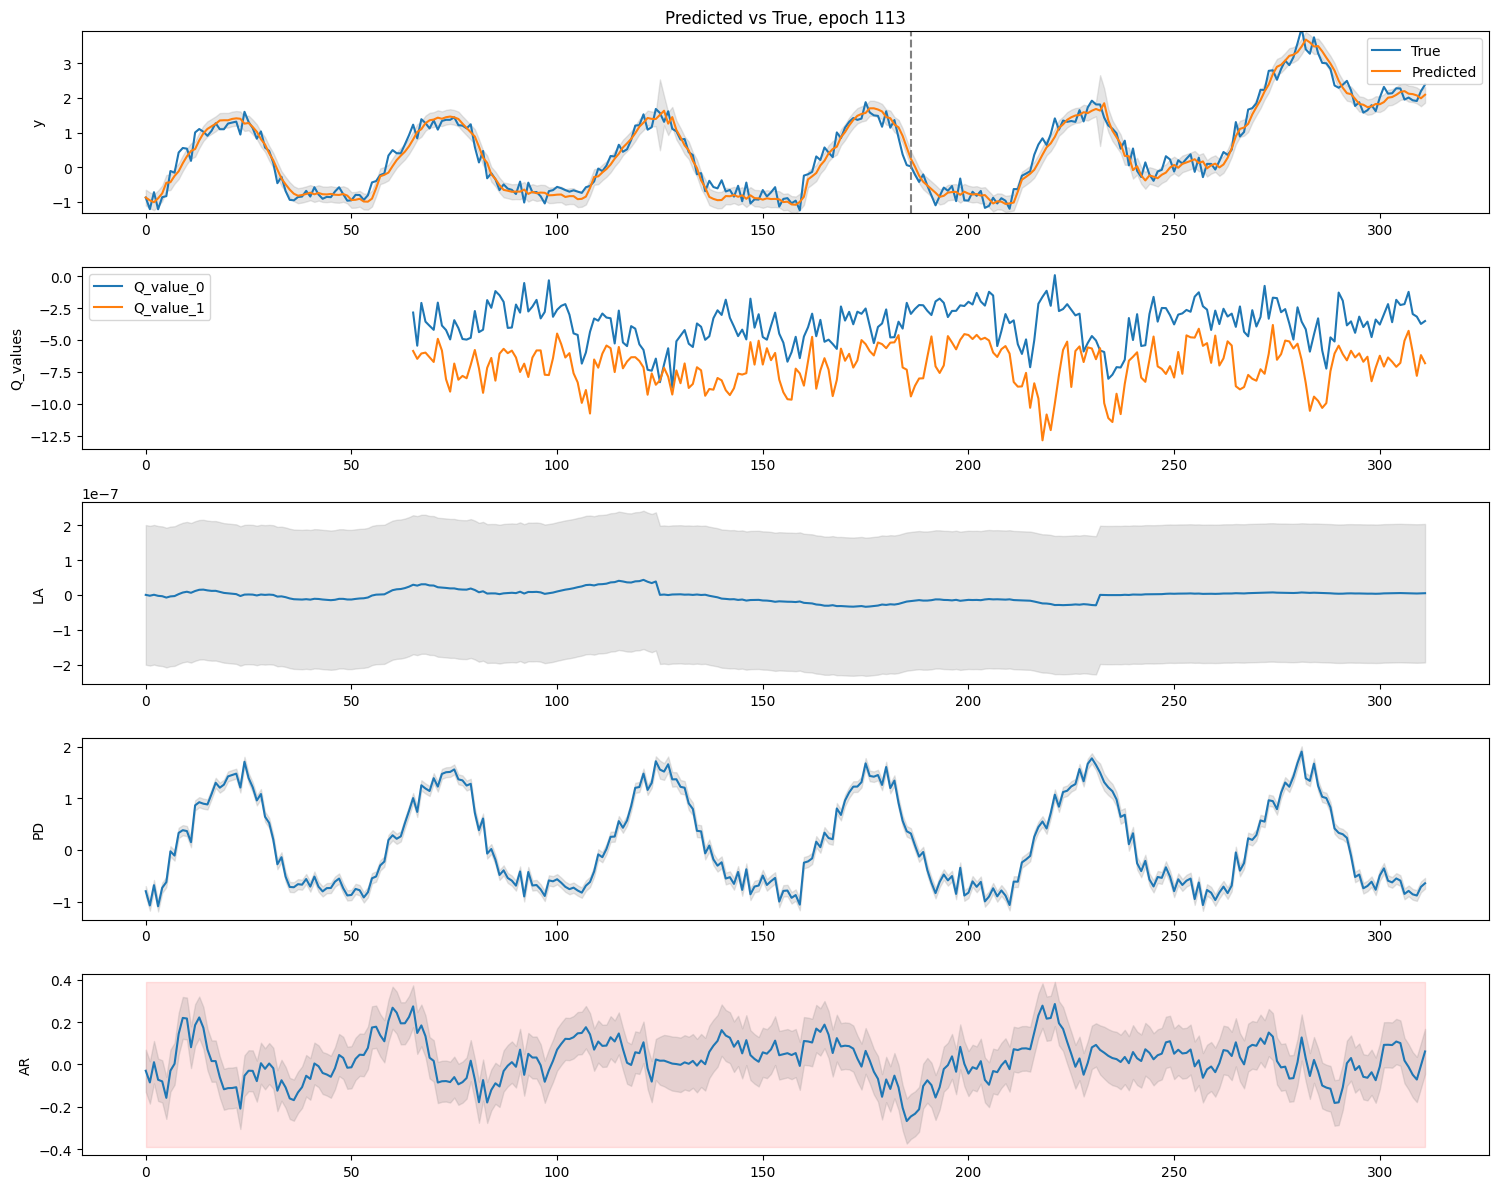

For validation episode: 0
Anomaly is injected: True
TP = 0, FP = 1, FN = 0, lambda = [1]
For validation episode: 1
Anomaly is injected: True
TP = 1, FP = 1, FN = 0, lambda = [1, 0.5100671140939597]
For validation episode: 2
Anomaly is injected: True
TP = 1, FP = 2, FN = 0, lambda = [1, 0.5100671140939597, 1]
For validation episode: 3
Anomaly is injected: True
TP = 1, FP = 3, FN = 0, lambda = [1, 0.5100671140939597, 1, 1]
For validation episode: 4
Anomaly is injected: True
TP = 1, FP = 4, FN = 0, lambda = [1, 0.5100671140939597, 1, 1, 1]
For validation episode: 5
Anomaly is injected: True
TP = 2, FP = 4, FN = 0, lambda = [1, 0.5100671140939597, 1, 1, 1, 0.6073059360730594]
For validation episode: 6
Anomaly is injected: True
TP = 2, FP = 5, FN = 0, lambda = [1, 0.5100671140939597, 1, 1, 1, 0.6073059360730594, 1]
For validation episode: 7
Anomaly is injected: True
TP = 2, FP = 6, FN = 0, lambda = [1, 0.5100671140939597, 1, 1, 1, 0.6073059360730594, 1, 1]
For validation episode: 8
Anomaly 

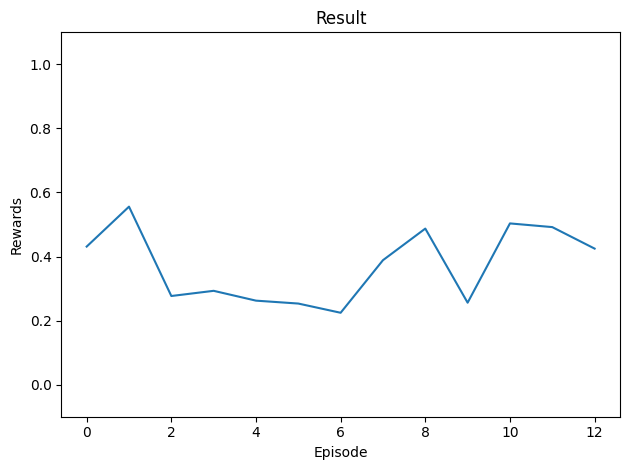

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

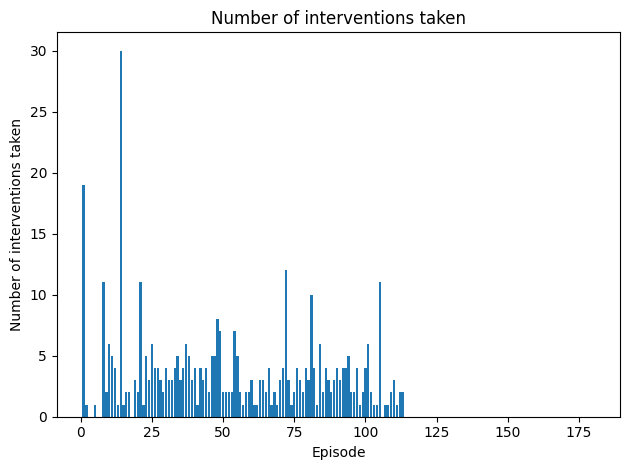

In [8]:
agents_RL.load_synthetic_ts(datetime_save_path='data/CASC_LGA007PIAP_E010_2024_07/RLDS_y_datetime_200episodes_V2.csv',
                            observation_save_path='data/CASC_LGA007PIAP_E010_2024_07/RLDS_y_observation_200episodes_V2.csv')
agents_RL.plot_synthetic_ts()

# Training
agents_RL.train(num_episodes = 200, step_look_back = 64, abnormal_ts_percentage = 1, anomaly_range = [-0.05, 0.05],
                init_z = init_z, init_Sz = init_Sz, init_mu_preds_lstm = init_mu_lstm, init_var_preds_lstm = init_var_lstm,
                batchsize = 128, TAU = 0.005, plot_samples = True, learning_curve_ylim = [-1000, 200],
                early_stopping = True, patience = 10, validation_episode_num = 20, early_stop_start=100,
                agent_net_save_path = agent_model_path, cost_of_intervention=10.255369087312996/4)

In [9]:
from itertools import count
import torch
from src.RL_functions.dqn_lstm_agent import *

step_look_back = 64
env = LSTM_KF_Env(render_mode=None, data_loader=BDLM.test_dtl, \
                    ts_model=BDLM.model, step_look_back=step_look_back)

state, info = env.reset(z=init_z, Sz=init_Sz, mu_preds_lstm = copy.deepcopy(init_mu_lstm), var_preds_lstm = copy.deepcopy(init_var_lstm),
                        net_test = LSTM_net, init_mu_W2b = init_mu_W2b, init_var_W2b = init_var_W2b, phi_AR=BDLM.phi_AR, Sigma_AR=BDLM.Sigma_AR,
                        phi_AA = BDLM.phi_AA, Sigma_AA_ratio = BDLM.Sigma_AA_ratio)

intervention_index =[]
intervention_taken = False
LA_var_stationary = BDLM.Sigma_AA_ratio *  BDLM.Sigma_AR/(1 - BDLM.phi_AA**2)
AR_std_stationary = np.sqrt(BDLM.Sigma_AR/(1 - BDLM.phi_AR**2))
if step_look_back == 64:
    seg_len = 8
RL_step_taken = 0
Q_values_all = []
for t in count():
    state = torch.tensor(state['hidden_states'],\
                        dtype=torch.float32, device='cpu').unsqueeze(0)
    state = normalize_tensor_two_parts(state, 0, np.sqrt(LA_var_stationary),\
                                        0, AR_std_stationary, seg_len)
    action = agents_RL._select_action(state, greedy=True)
    action = action.item()

    # Track Q values
    with torch.no_grad():
        Q_values_t = agents_RL.policy_net(state)[0].tolist()
        Q_values_all.append(Q_values_t)

    if RL_step_taken >= 900-64:
        state, reward, terminated, truncated, info = env.step(action, cost_intervention=agents_RL.cost_intervention, add_anomaly = True, anomaly_scale = 1.1e-2*(RL_step_taken-(900-64)))
    else:
        state, reward, terminated, truncated, info = env.step(action, cost_intervention=agents_RL.cost_intervention)

    # state, reward, terminated, truncated, info = env.step(action)

    RL_step_taken += 1

    if action == 1:
        intervention_index.append(t + step_look_back + 1)
        intervention_taken = True

    done = terminated or truncated
    if done:
        break

# Fill 65 rows of [nan, nan] values in front of Q_values_all
Q_values_all = [[np.nan, np.nan]] * 65 + Q_values_all
Q_values_all = np.array(Q_values_all).T

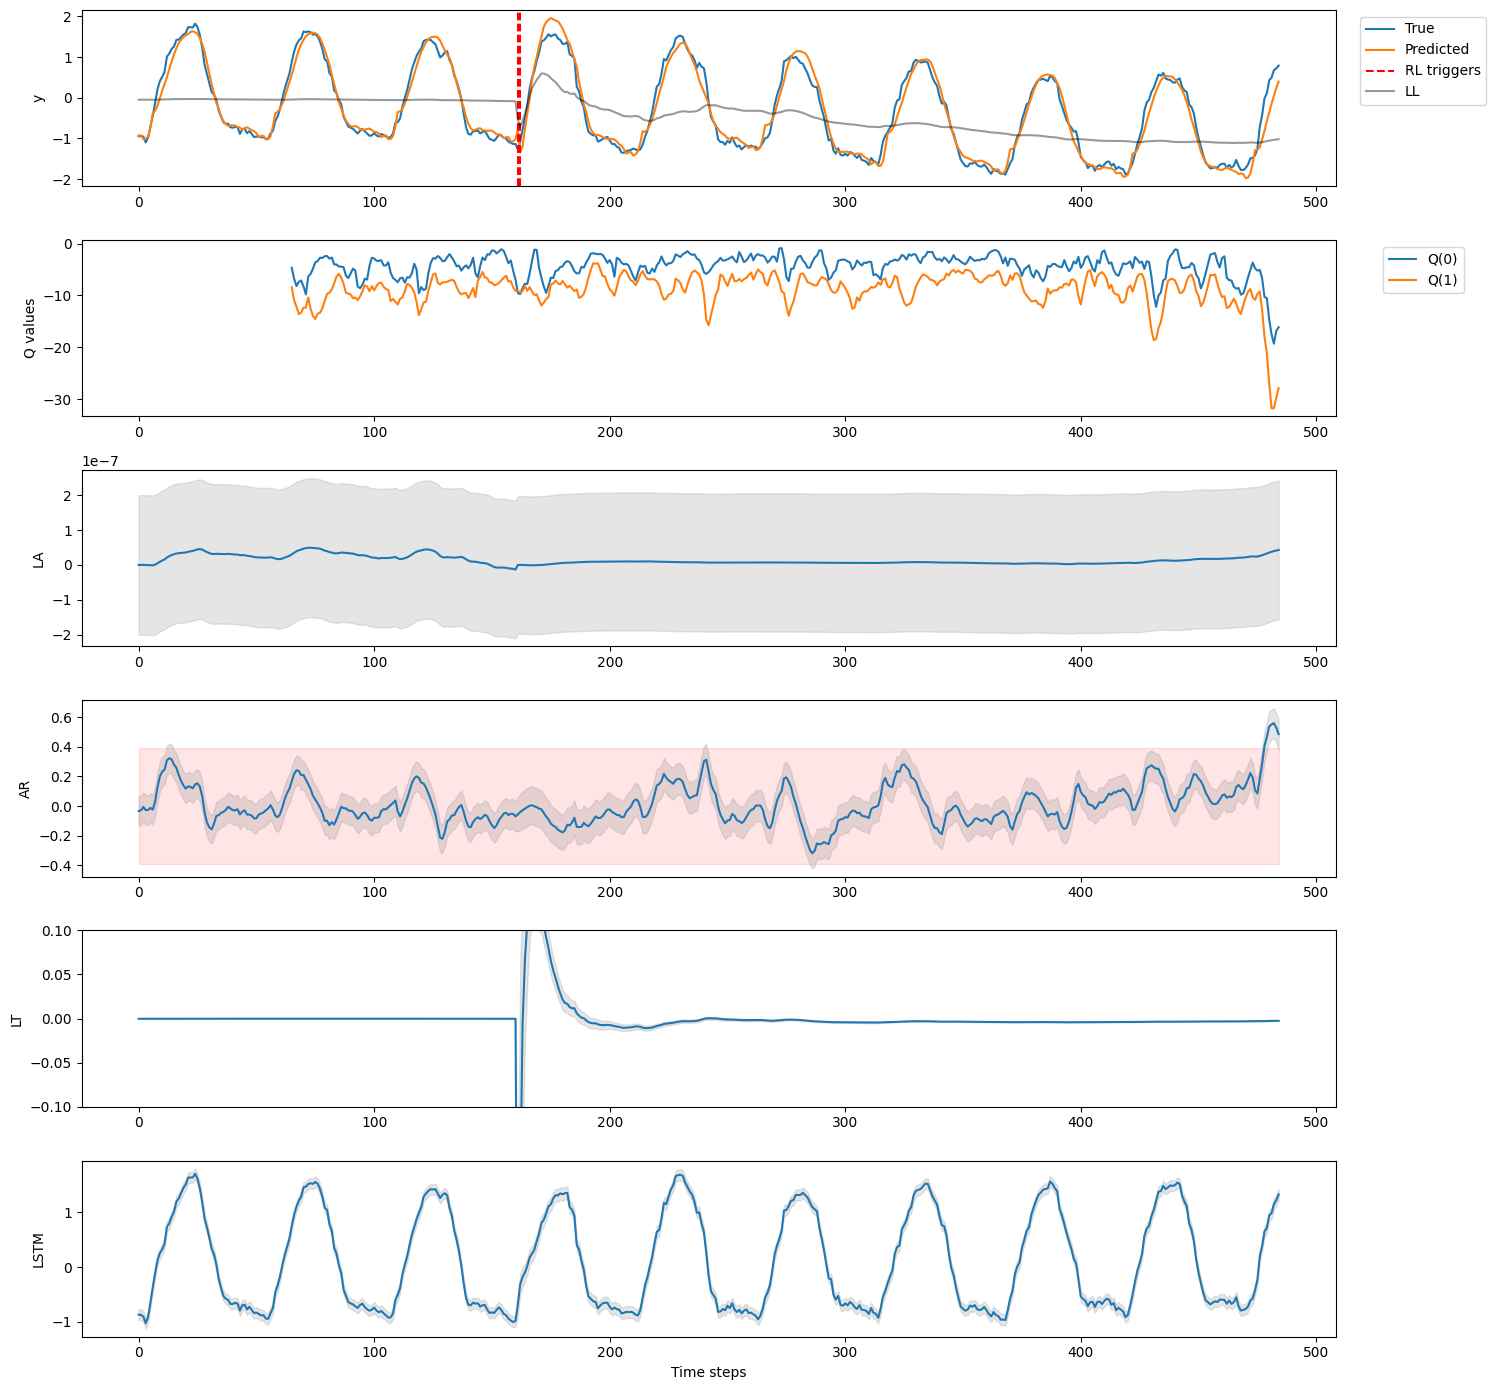

In [10]:
# Plot prediction
timesteps = np.arange(0, len(info['measurement_one_episode']), 1)
mu_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['mu'])
var_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['var'])
mu_prediction_one_episode = np.array(info['prediction_one_episode']['mu']).flatten()
var_prediction_one_episode = np.array(info['prediction_one_episode']['var']).flatten()
from matplotlib import gridspec
fig = plt.figure(figsize=(15, 14))
gs = gridspec.GridSpec(6, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[2])
ax2 = plt.subplot(gs[3])
ax3 = plt.subplot(gs[4])
ax4 = plt.subplot(gs[5])
ax5 = plt.subplot(gs[1])

ax0.plot(timesteps, info['measurement_one_episode'], label='True')
ax0.plot(timesteps, mu_prediction_one_episode , label='Predicted')
for count, i in enumerate(intervention_index):
    if count == 0:
        ax0.axvline(x=timesteps[i], color='r', linestyle='--', label='RL triggers')
    else:
        ax0.axvline(x=timesteps[i], color='r', linestyle='--')
ax0.plot(timesteps, mu_hidden_states_one_episode[:,0], color = 'k',alpha=0.4, label='LL')
# ax0.fill_between(timesteps, mu_hidden_states_one_episode[:,0] - np.sqrt(var_hidden_states_one_episode[:,0,0]),\
#                     mu_hidden_states_one_episode[:,0] + np.sqrt(var_hidden_states_one_episode[:,0,0]), color='gray', alpha=0.2)
ax0.set_ylabel('y')
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.07,1))


ax1.plot(timesteps, mu_hidden_states_one_episode[:,2], label='LA')
ax1.fill_between(timesteps, mu_hidden_states_one_episode[:,2] - np.sqrt(var_hidden_states_one_episode[:,2,2]),\
                    mu_hidden_states_one_episode[:,2] + np.sqrt(var_hidden_states_one_episode[:,2,2]), color='gray', alpha=0.2)
ax1.set_ylabel('LA')

ax2.fill_between(timesteps, np.zeros_like(timesteps)-3*AR_std_stationary, np.zeros_like(timesteps)+3*AR_std_stationary, color='red', alpha=0.1)
ax2.plot(timesteps, mu_hidden_states_one_episode[:,-2], label='AR')
ax2.fill_between(timesteps, mu_hidden_states_one_episode[:,-2] - np.sqrt(var_hidden_states_one_episode[:,-2,-2]),\
                    mu_hidden_states_one_episode[:,-2] + np.sqrt(var_hidden_states_one_episode[:,-2,-2]), color='gray', alpha=0.2)
ax2.set_ylabel('AR')
# ax2.set_ylim(-1.1, 1.1)

ax3.plot(timesteps, mu_hidden_states_one_episode[:,1], label='LT')
ax3.fill_between(timesteps, mu_hidden_states_one_episode[:,1] - np.sqrt(var_hidden_states_one_episode[:,1,1]),\
                    mu_hidden_states_one_episode[:,1] + np.sqrt(var_hidden_states_one_episode[:,1,1]), color='gray', alpha=0.2)
ax3.set_ylabel('LT')
ax3.set_ylim(-0.1,0.1)

ax4.plot(timesteps, mu_hidden_states_one_episode[:,-1], label='LSTM')
ax4.fill_between(timesteps, mu_hidden_states_one_episode[:,-1] - np.sqrt(var_hidden_states_one_episode[:,-1,-1]),\
                    mu_hidden_states_one_episode[:,-1] + np.sqrt(var_hidden_states_one_episode[:,-1,-1]), color='gray', alpha=0.2)
ax4.set_ylabel('LSTM')
ax4.set_xlabel('Time steps')

ax5.plot(timesteps, Q_values_all[0], label='Q(0)')
ax5.plot(timesteps, Q_values_all[1], label='Q(1)')
ax5.set_ylabel('Q values')
# set x axis to be the same as ax0
ax5.set_xlim(ax0.get_xlim())
ax5.legend(loc='upper center', bbox_to_anchor=(1.07,1))

plt.show()

In [11]:
# from itertools import count
# import torch
# from src.RL_functions.dqn_lstm_agent import *

# train_dtl = SyntheticTimeSeriesDataloader(
#                     x_file='data/CASC_LGA007PIAP_E010_2024_07/RLDS_y_observation_200episodes_V2.csv',
#                     select_column=5,
#                     date_time_file='data/CASC_LGA007PIAP_E010_2024_07/RLDS_y_datetime_200episodes_V2.csv',
#                     add_anomaly = False,
#                     # anomaly_magnitude=np.random.uniform(-0.05, 0.05),
#                     # anomaly_start=anm_pos,
#                     x_mean=BDLM.train_dtl.x_mean,
#                     x_std=BDLM.train_dtl.x_std,
#                     output_col=BDLM.output_col,
#                     input_seq_len=BDLM.input_seq_len,
#                     output_seq_len=BDLM.output_seq_len,
#                     num_features=BDLM.num_features,
#                     stride=BDLM.seq_stride,
#                     time_covariates=BDLM.time_covariates,
#                 )

# step_look_back = 64
# env = LSTM_KF_Env(render_mode=None, data_loader=train_dtl , \
#                     ts_model=BDLM.model, step_look_back=step_look_back)

# state, info = env.reset(z=init_z, Sz=init_Sz, mu_preds_lstm = copy.deepcopy(init_mu_lstm), var_preds_lstm = copy.deepcopy(init_var_lstm),
#                         net_test = LSTM_net, init_mu_W2b = init_mu_W2b, init_var_W2b = init_var_W2b, phi_AR=BDLM.phi_AR, Sigma_AR=BDLM.Sigma_AR,
#                         phi_AA = BDLM.phi_AA, Sigma_AA_ratio = BDLM.Sigma_AA_ratio)

# intervention_index =[]
# intervention_taken = False
# LA_var_stationary = BDLM.Sigma_AA_ratio *  BDLM.Sigma_AR/(1 - BDLM.phi_AA**2)
# AR_std_stationary = np.sqrt(BDLM.Sigma_AR/(1 - BDLM.phi_AR**2))
# if step_look_back == 64:
#     seg_len = 8
# RL_step_taken = 0
# Q_values_all = []
# reward_one_episode = 0
# Q_true = 0
# for t in count():
#     state = torch.tensor(state['hidden_states'],\
#                         dtype=torch.float32, device='cpu').unsqueeze(0)
#     state = normalize_tensor_two_parts(state, 0, np.sqrt(LA_var_stationary),\
#                                         0, AR_std_stationary, seg_len)
#     action = agents_RL._select_action(state, greedy=True)
#     action = action.item()

#     if RL_step_taken == 0:
#         action = 1
#     else:
#         action = 0

#     # Track Q values
#     with torch.no_grad():
#         Q_values_t = agents_RL.policy_net(state)[0].tolist()
#         Q_values_all.append(Q_values_t)

#     anomaly_pos = 900

#     if RL_step_taken >= anomaly_pos:
#         state, reward, terminated, truncated, info = env.step(action, cost_intervention=agents_RL.cost_intervention, add_anomaly = True, anomaly_scale = 1.1e-2*(RL_step_taken-(anomaly_pos)))
#     else:
#         state, reward, terminated, truncated, info = env.step(action, cost_intervention=agents_RL.cost_intervention)

#     Q_true += 0.999**(t+1) * reward

#     reward_one_episode += reward

#     # state, reward, terminated, truncated, info = env.step(action)

#     RL_step_taken += 1

#     if action == 1:
#         intervention_index.append(t + step_look_back + 1)
#         intervention_taken = True

#     done = terminated or truncated
#     if done:
#         break

# print('Q_true:', Q_true)
# # Plot prediction
# timesteps = np.arange(0, len(info['measurement_one_episode']), 1)
# mu_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['mu'])
# var_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['var'])
# mu_prediction_one_episode = np.array(info['prediction_one_episode']['mu']).flatten()
# var_prediction_one_episode = np.array(info['prediction_one_episode']['var']).flatten()
# from matplotlib import gridspec
# fig = plt.figure(figsize=(15, 14))
# gs = gridspec.GridSpec(6, 1)
# ax0 = plt.subplot(gs[0])
# ax1 = plt.subplot(gs[2])
# ax2 = plt.subplot(gs[3])
# ax3 = plt.subplot(gs[4])
# ax4 = plt.subplot(gs[5])
# ax5 = plt.subplot(gs[1])

# ax0.plot(timesteps, info['measurement_one_episode'], label='True')
# ax0.plot(timesteps, mu_prediction_one_episode , label='Predicted')
# ax0.fill_between(timesteps, mu_prediction_one_episode - np.sqrt(var_prediction_one_episode),\
#                     mu_prediction_one_episode + np.sqrt(var_prediction_one_episode), color='gray', alpha=0.2)
# # for count, i in enumerate(intervention_index):
# #     if count == 0:
# #         ax0.axvline(x=timesteps[i], color='r', linestyle='--', label='RL triggers')
# #     else:
# #         ax0.axvline(x=timesteps[i], color='r', linestyle='--')
# ax0.plot(timesteps, mu_hidden_states_one_episode[:,0], color = 'k',alpha=0.4, label='LL')
# ax0.fill_between(timesteps, mu_hidden_states_one_episode[:,0] - np.sqrt(var_hidden_states_one_episode[:,0,0]),\
#                     mu_hidden_states_one_episode[:,0] + np.sqrt(var_hidden_states_one_episode[:,0,0]), color='gray', alpha=0.2)
# ax0.set_ylabel('y')
# handles, labels = ax0.get_legend_handles_labels()
# ax0.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.07,1))
# delta_max_min = np.max(mu_prediction_one_episode) - np.min(mu_prediction_one_episode)
# ax0.set_ylim(np.min(mu_prediction_one_episode)-0.05*delta_max_min, np.max(mu_prediction_one_episode)+0.05*delta_max_min)


# ax1.plot(timesteps, mu_hidden_states_one_episode[:,2], label='LA')
# ax1.fill_between(timesteps, mu_hidden_states_one_episode[:,2] - np.sqrt(var_hidden_states_one_episode[:,2,2]),\
#                     mu_hidden_states_one_episode[:,2] + np.sqrt(var_hidden_states_one_episode[:,2,2]), color='gray', alpha=0.2)
# ax1.set_ylabel('LA')

# ax2.fill_between(timesteps, np.zeros_like(timesteps)-3*AR_std_stationary, np.zeros_like(timesteps)+3*AR_std_stationary, color='red', alpha=0.1)
# ax2.plot(timesteps, mu_hidden_states_one_episode[:,-2], label='AR')
# ax2.fill_between(timesteps, mu_hidden_states_one_episode[:,-2] - np.sqrt(var_hidden_states_one_episode[:,-2,-2]),\
#                     mu_hidden_states_one_episode[:,-2] + np.sqrt(var_hidden_states_one_episode[:,-2,-2]), color='gray', alpha=0.2)
# ax2.set_ylabel('AR')
# # ax2.set_ylim(-1.1, 1.1)

# ax3.plot(timesteps, mu_hidden_states_one_episode[:,1], label='LT')
# ax3.fill_between(timesteps, mu_hidden_states_one_episode[:,1] - np.sqrt(var_hidden_states_one_episode[:,1,1]),\
#                     mu_hidden_states_one_episode[:,1] + np.sqrt(var_hidden_states_one_episode[:,1,1]), color='gray', alpha=0.2)
# ax3.set_ylabel('LT')
# ax3.set_ylim(-0.1,0.1)

# ax4.plot(timesteps, mu_hidden_states_one_episode[:,-1], label='LSTM')
# ax4.fill_between(timesteps, mu_hidden_states_one_episode[:,-1] - np.sqrt(var_hidden_states_one_episode[:,-1,-1]),\
#                     mu_hidden_states_one_episode[:,-1] + np.sqrt(var_hidden_states_one_episode[:,-1,-1]), color='gray', alpha=0.2)
# ax4.set_ylabel('LSTM')
# ax4.set_xlabel('Time steps')

# # ax5.plot(timesteps, Q_values_all[0], label='Q(0)')
# # ax5.plot(timesteps, Q_values_all[1], label='Q(1)')
# # ax5.set_ylabel('Q values')
# # # set x axis to be the same as ax0
# # ax5.set_xlim(ax0.get_xlim())
# # ax5.legend(loc='upper center', bbox_to_anchor=(1.07,1))

# plt.show()

# print(reward_one_episode)